##캐글 데이터를 활용한 집값 예측  
하이퍼파라미터 튜닝 및 EDA 과정을 통한 모델의 성능을 향상하여 원하는 목표를 달성하는 과제  
목표: 캐글 리더보드의 private score 기준 110000 이하의 점수 얻기  
방법: 피쳐 엔지니어링, 하이퍼파라미터 튜닝(LGBMRegressor, XGBRegressor, RandomForestRegresso), 그리드 탐색, 블렌딩 방법    

[관련링크1](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)  
[관련링크2](https://injo.tistory.com/48)  
  
<feature 설명>   
ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 타겟 변수인 집의 가격  
bedrooms : 침실의 수  
bathrooms : 침실당 화장실 개수  
sqft_living : 주거 공간의 평방 피트  
sqft_lot : 부지의 평방 피트  
floors : 집의 층수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트  
sqft_basement : 지하실의 평방 피트  
yr_built : 집을 지은 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  


In [360]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [447]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

In [418]:
 #데이터 준비 
 data_dir = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
data = pd.concat((train, test), axis=0)

In [363]:
print(train.shape)
print(test.shape)

(15035, 21)
(6468, 20)


##Exploratory Data Analysis

In [364]:
data.head() #sqft_lot15=>재건축 후의 공간의 크기를 말하는 것이 아니라 가장 근접하는 집 15채의 크기를 나타냄

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [365]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,1.503500e+04,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,5.406827e+05,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,3.715247e+05,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,4.500000e+05,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,6.450000e+05,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [419]:
#날짜 정수형으로 바꾸기 
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

#id 삭제 
del data['id']

In [367]:
# correlation 
data.corr()['price'].sort_values(axis=0, ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
date             0.007717
zipcode         -0.051498
Name: price, dtype: float64

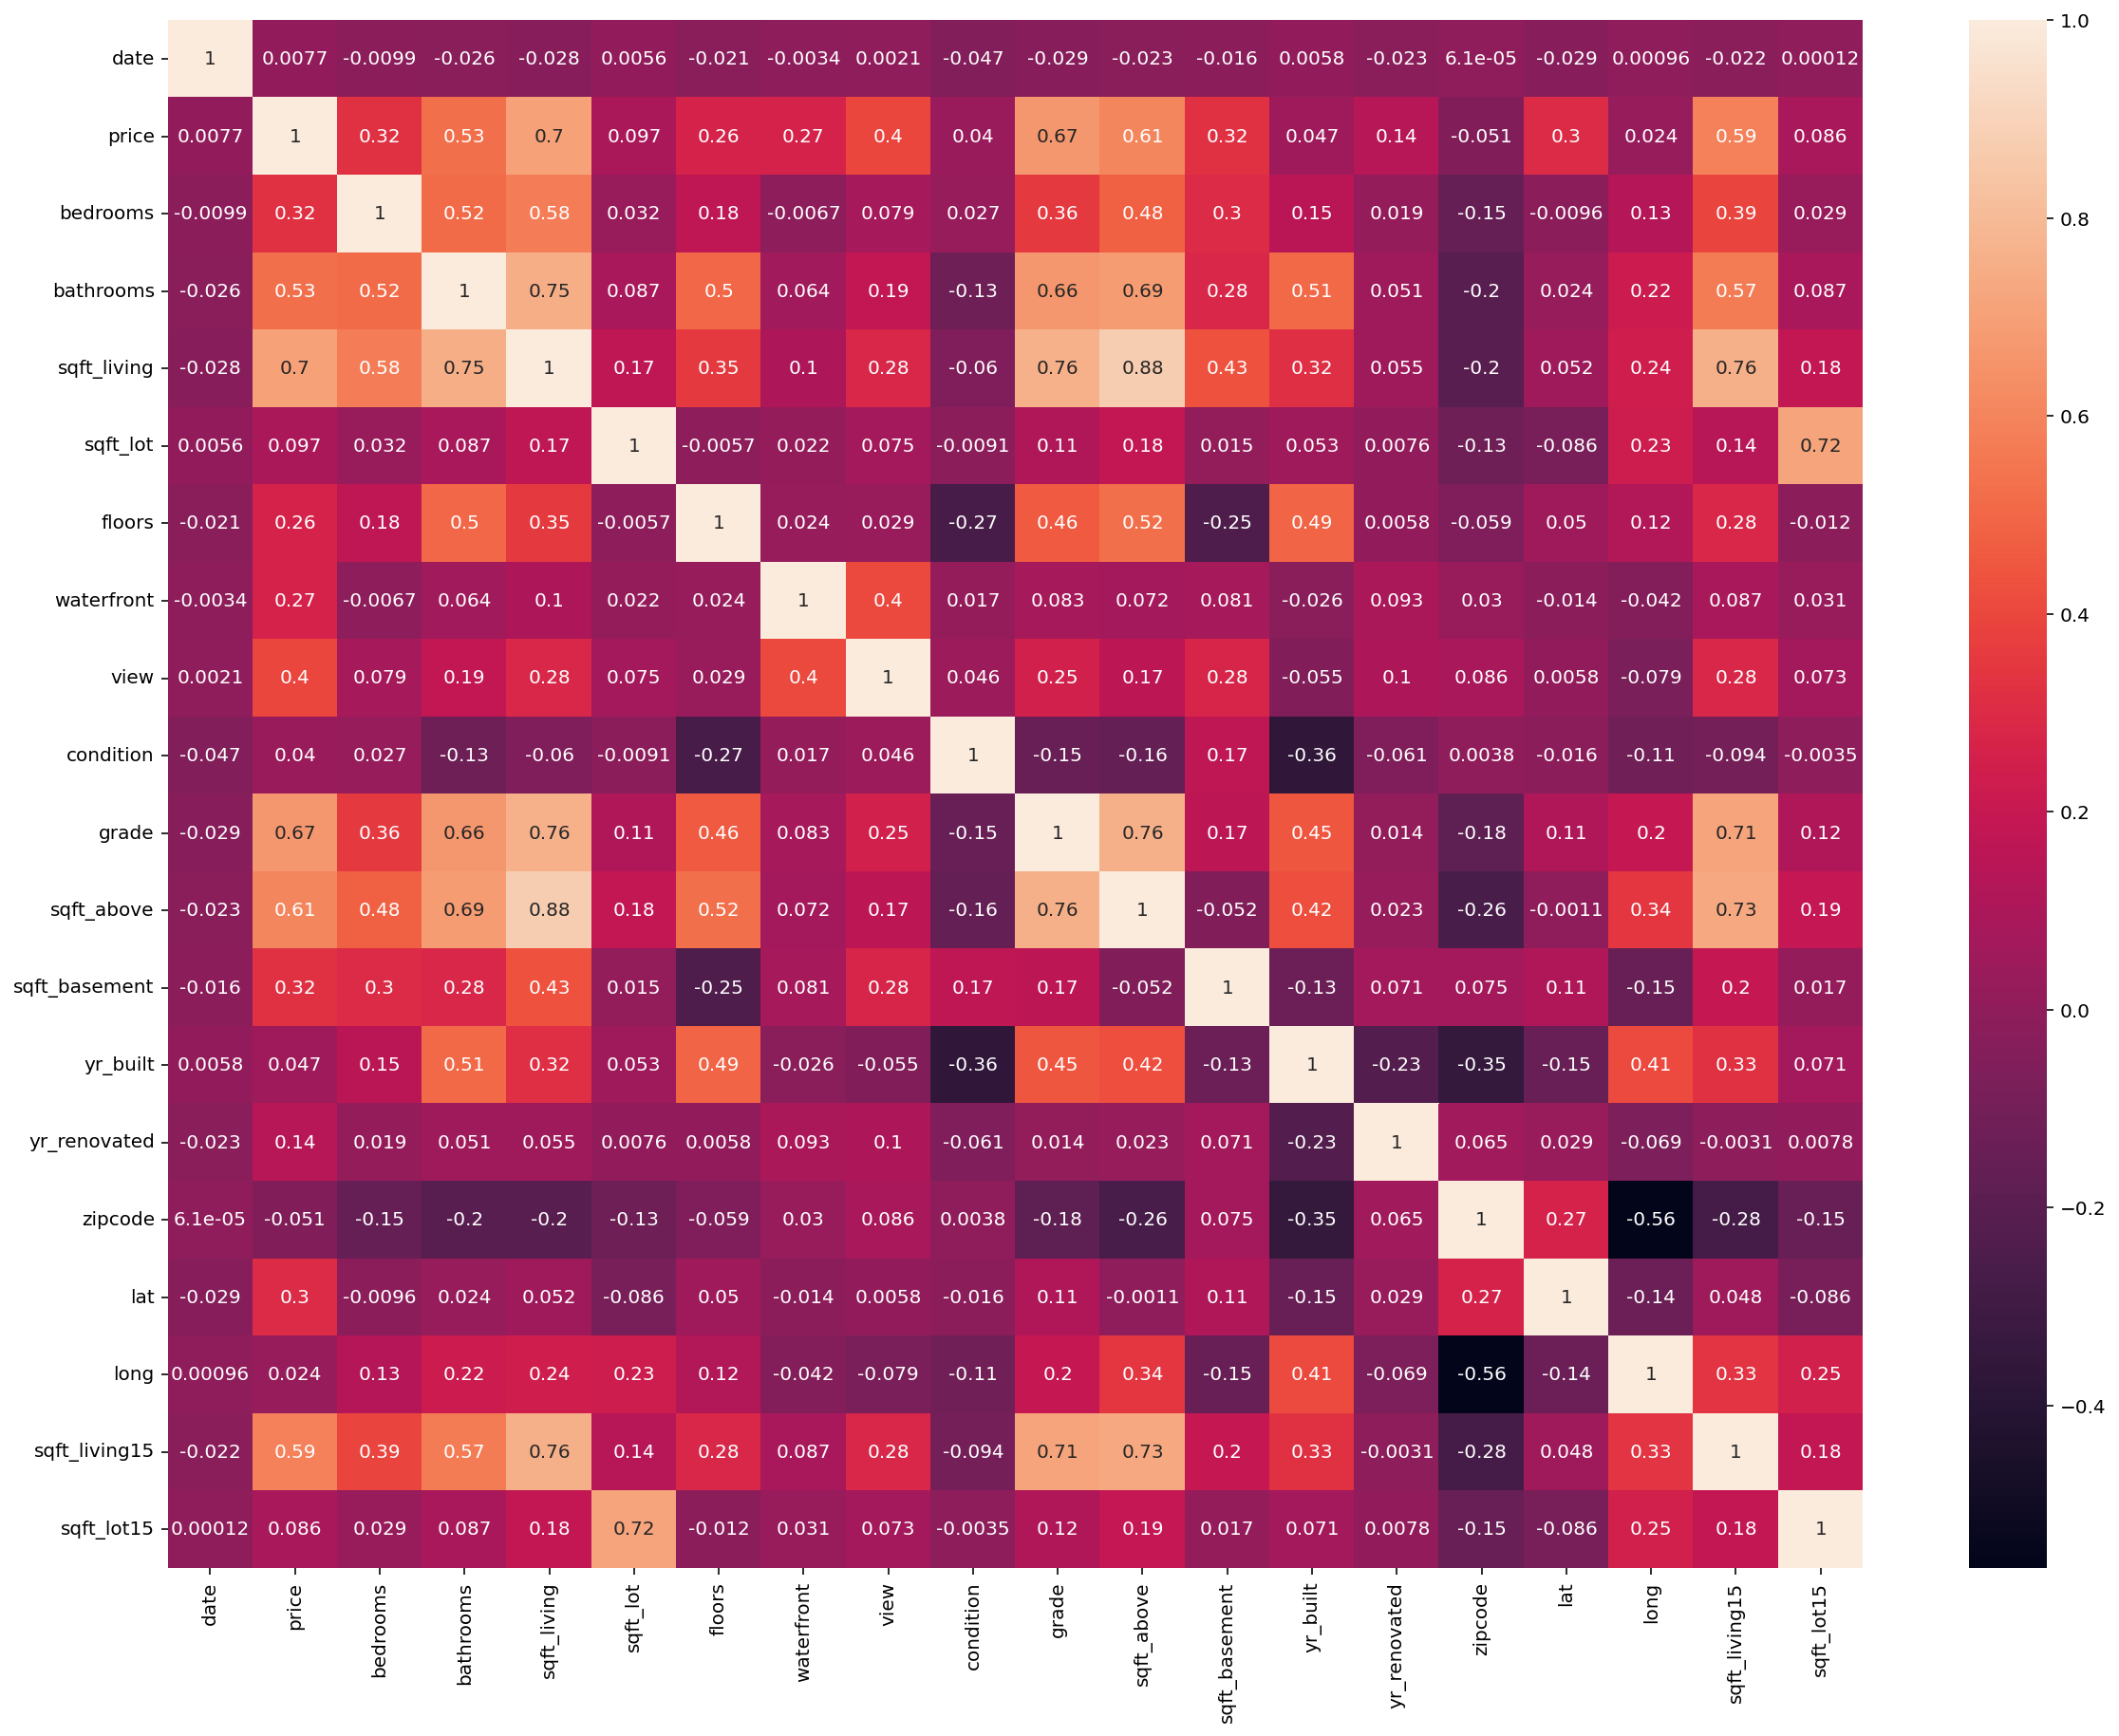

In [368]:
#heatmap
corr = data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot=True)
plt.show()

In [369]:
print(data['zipcode'].sort_values().unique()) #유일값 확인
print(len(data['zipcode'].unique())) #zipcode 총 개수 

[98001 98002 98003 98004 98005 98006 98007 98008 98010 98011 98014 98019
 98022 98023 98024 98027 98028 98029 98030 98031 98032 98033 98034 98038
 98039 98040 98042 98045 98052 98053 98055 98056 98058 98059 98065 98070
 98072 98074 98075 98077 98092 98102 98103 98105 98106 98107 98108 98109
 98112 98115 98116 98117 98118 98119 98122 98125 98126 98133 98136 98144
 98146 98148 98155 98166 98168 98177 98178 98188 98198 98199]
70


####zipcode  
처음에 zipcode와 가격과 상관이 없어보여 삭제할까 했으나 미국에서는 zipcode가 집 값을 어느 정도 보여주는 척도라 판단하였다.  
우선 우편번호의 유일값은 총 70개임을 확인했고 이를 goupby를 활용해 각 우편번호 별로 몇 개인지 세서 별도의 컬럼 count를 생성했다.  
zipcode를 price 순으로 정렬한 다음 총 7개 구간으로 나누고(0~6)이를 딕셔너리에 저장한 후 apply함수를 통해 encoding을 해주었다.  
집 값이 비싸면 6에 가깝고 상대적으로 저렴하면 0에 가깝다.  

In [420]:
#data['zipcode'] = data['zipcode'].astype(str) #zipcode 문자열로 바꿈 
zipcode = data.groupby('zipcode').agg(np.mean) #mean함수 활용하여 zipcode에 적용  
zipcode.reset_index(inplace=True) #index 재설정 

#각각의 zipcode가 몇 개 있는지 세기
data['count'] = 1
count_zipcode = data.groupby('zipcode').sum() #sum함수 활용하여 zipcode 적용
count_zipcode.reset_index(inplace=True) 
count_zipcode = count_zipcode[['zipcode','count']] #zipcode와 count만 따로 빼서 데이터 프레임 만들기 

data.drop(['count'], axis = 1, inplace = True) #count 열 제거 

sub_data = pd.merge(zipcode, count_zipcode, how='left', on=['zipcode']) #zipcode_data, count_zipcode
sub_data.head(2)

,zipcode,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,count
0,98001,201438.516667,272469.577406,3.386111,2.006944,1903.194444,14922.361111,1.430556,0.0,0.102778,3.333333,7.294444,1722.666667,180.527778,1980.805556,44.044444,47.308986,-122.270617,1829.266667,11192.036111,360
1,98002,201440.366834,235664.526718,3.326633,1.839196,1627.743719,7517.633166,1.334171,0.0,0.010050,3.743719,6.693467,1522.537688,105.206030,1967.773869,59.889447,47.308780,-122.213357,1479.030151,7585.482412,199


In [421]:
sub_data = sub_data.sort_values('price') #평균을 보면 98039, 98004, 98040, 98112 순으로 비쌌다. 
sub_data.drop(['count'], axis = 1, inplace = True) 
print(sub_data.shape)
print(data.shape)

(70, 20)
(21503, 20)


In [422]:
#우편번호를 집 값 순으로 encoding
zipcode_exp = sub_data['zipcode']
dic = {}

cnt = 0
for zipcode in zipcode_exp:
    dic[zipcode] = cnt//10
    cnt += 1

In [424]:
lst = []
series = data['zipcode']

for d in series:
    for key, value in dic.items():
        if d == key:
            lst.append(value)


In [427]:
#encode labeling
data['zipcode_encoding'] = lst
#encode후 결측치 확인 
for c in data.columns: 
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
zipcode_encoding : 0


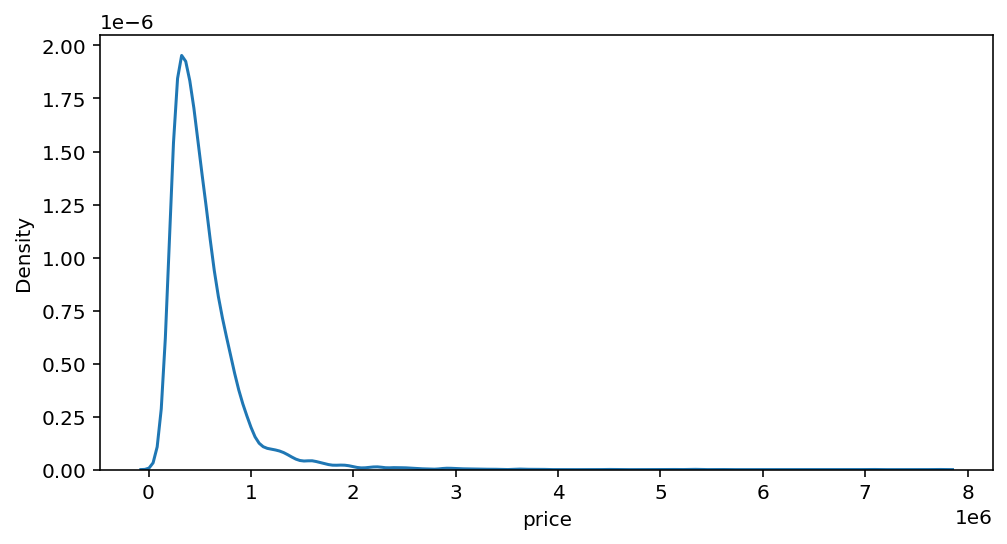

In [377]:
#price 분포도 확인
plt.figure(figsize = (8, 4))
sns.kdeplot(data['price'])
plt.show()

####sqft_living  
sqft_living이 넓을수록 가격은 상승하는 추세를 보였다.  
sqft_above와 sqft_basement를 더하니 sqft_living과 동일한 추세를 보인 것으로 보아 sqft_living은 sqft_basement와 sqft_living을 합한 column이라고 판단했다.  

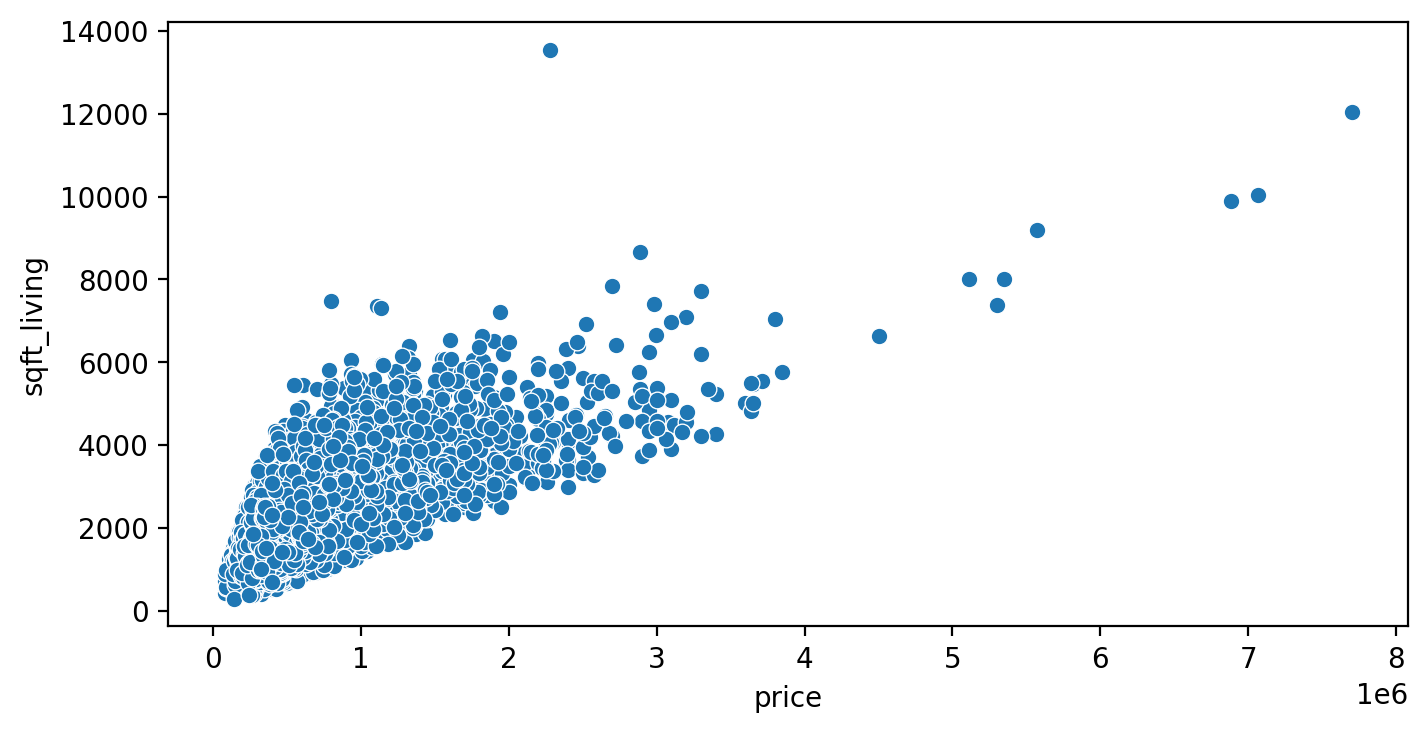

In [378]:
# sqft_living, price 관계 => sqft_living 넓을수록 price 상승 
plt.figure(figsize = (8, 4), dpi = 100)
sns.scatterplot(data = data, x = 'price', y = 'sqft_living')
plt.show()

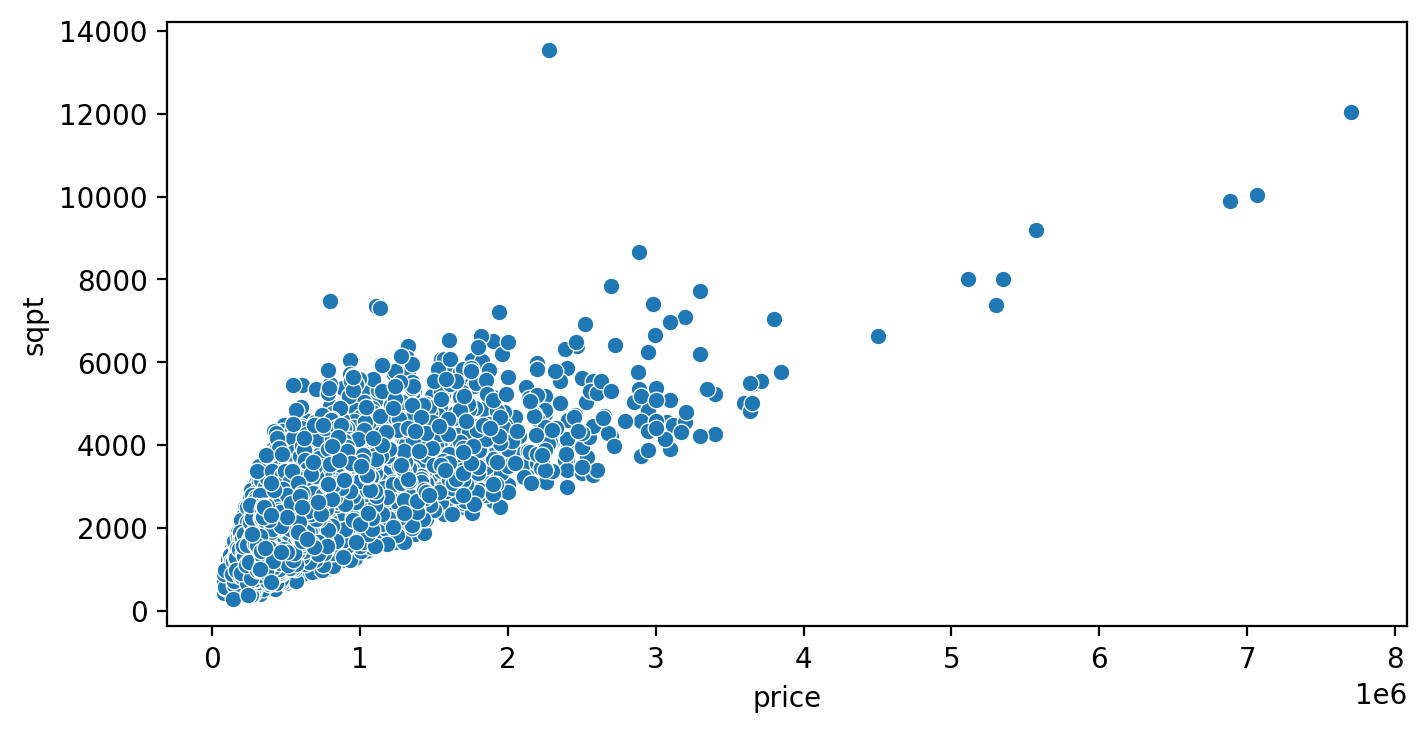

In [379]:
data['sqpt'] = data['sqft_above'] + data['sqft_basement']
plt.figure(figsize = (8, 4), dpi = 100)
sns.scatterplot(data = data, x = 'price', y = 'sqpt')
plt.show()

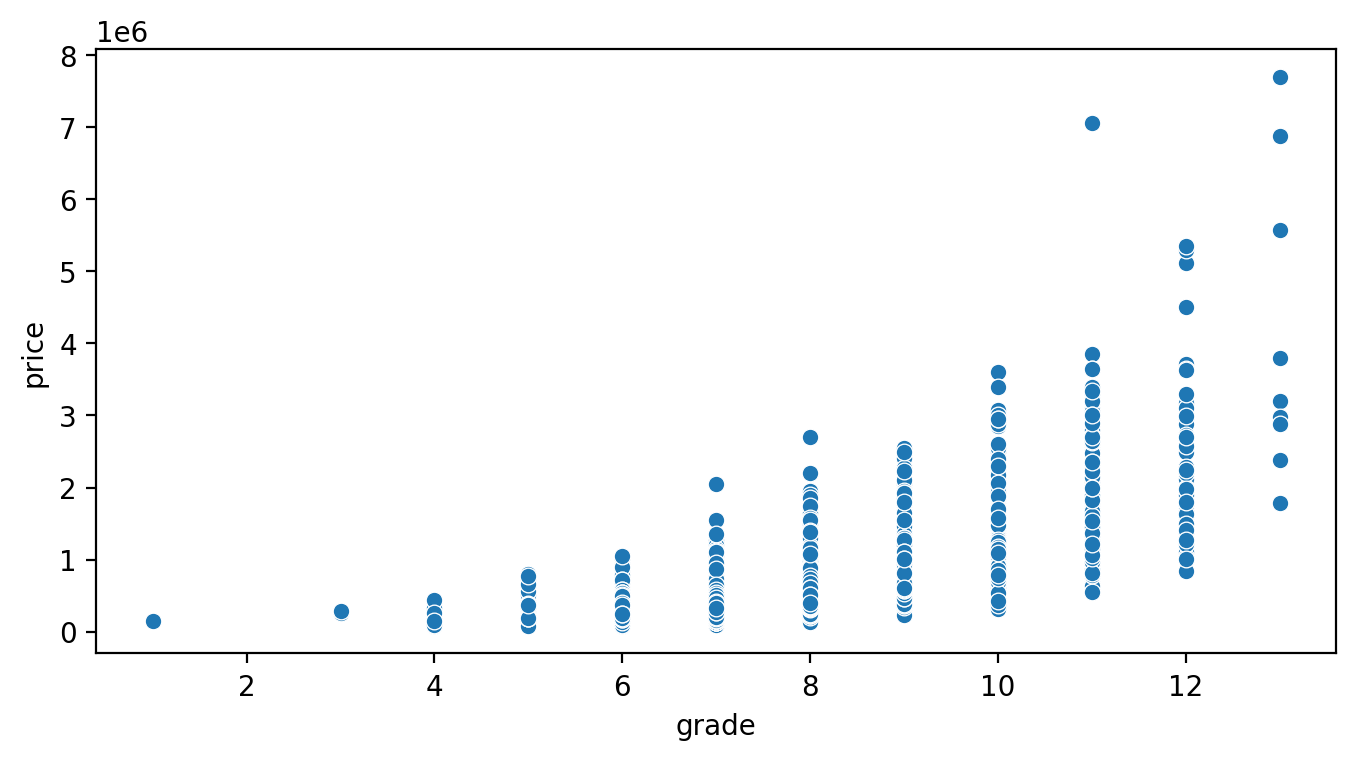

In [380]:
#grade
plt.figure(figsize = (8, 4),dpi = 100)
sns.scatterplot(data = data, x = 'grade', y = 'price')
plt.show()

In [381]:
condition1 = data['grade'] > 10
condition2 = data['grade'] < 12 
condition3 = data['price'] > 6000000.0
data.loc[(condition1 & condition2) & condition3] #이상치 확인  

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_encoding,sqpt
2775,201406,7062500.0,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449,NaN,10040


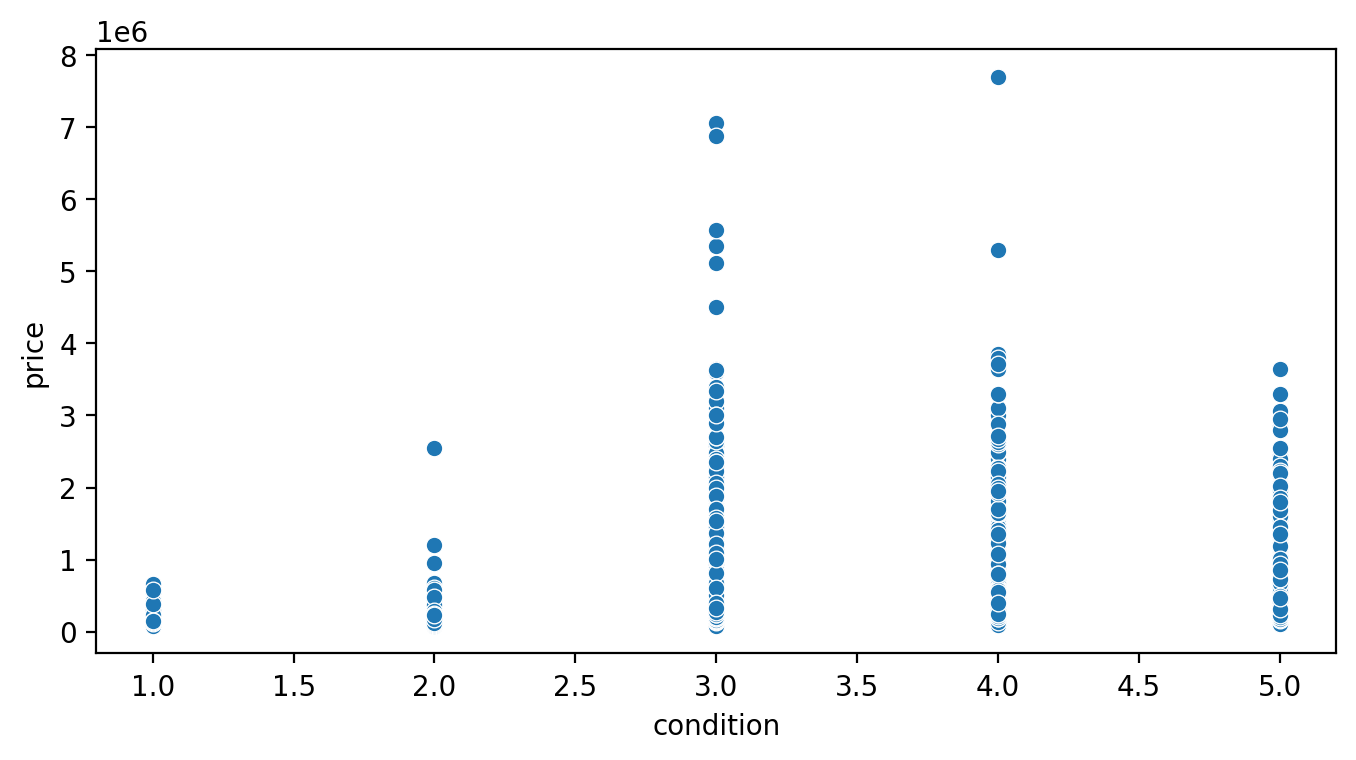

In [382]:
#condition
plt.figure(figsize = (8, 4),dpi = 100)
sns.scatterplot(data = data, x = 'condition', y = 'price')
plt.show()

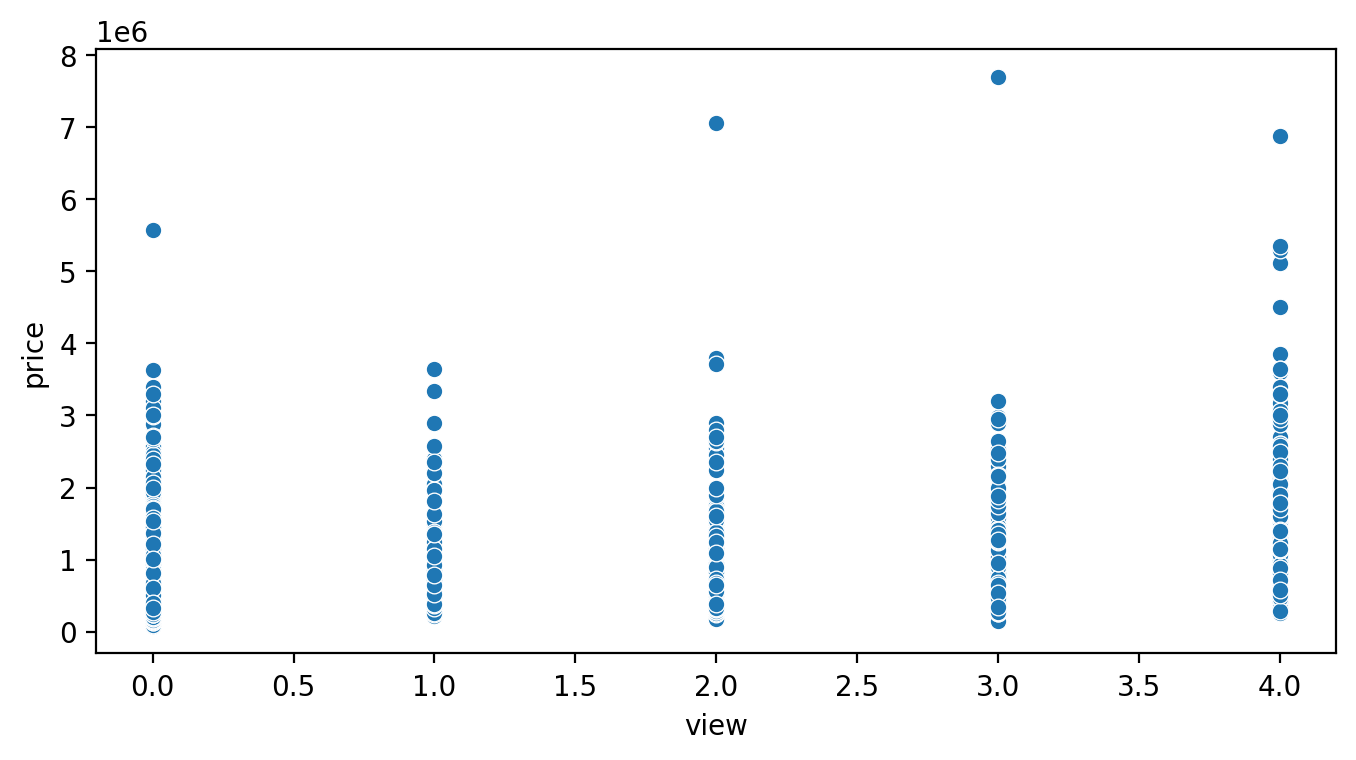

In [383]:
#view
plt.figure(figsize = (8, 4),dpi = 100)
sns.scatterplot(data = data, x = 'view', y = 'price')
plt.show()

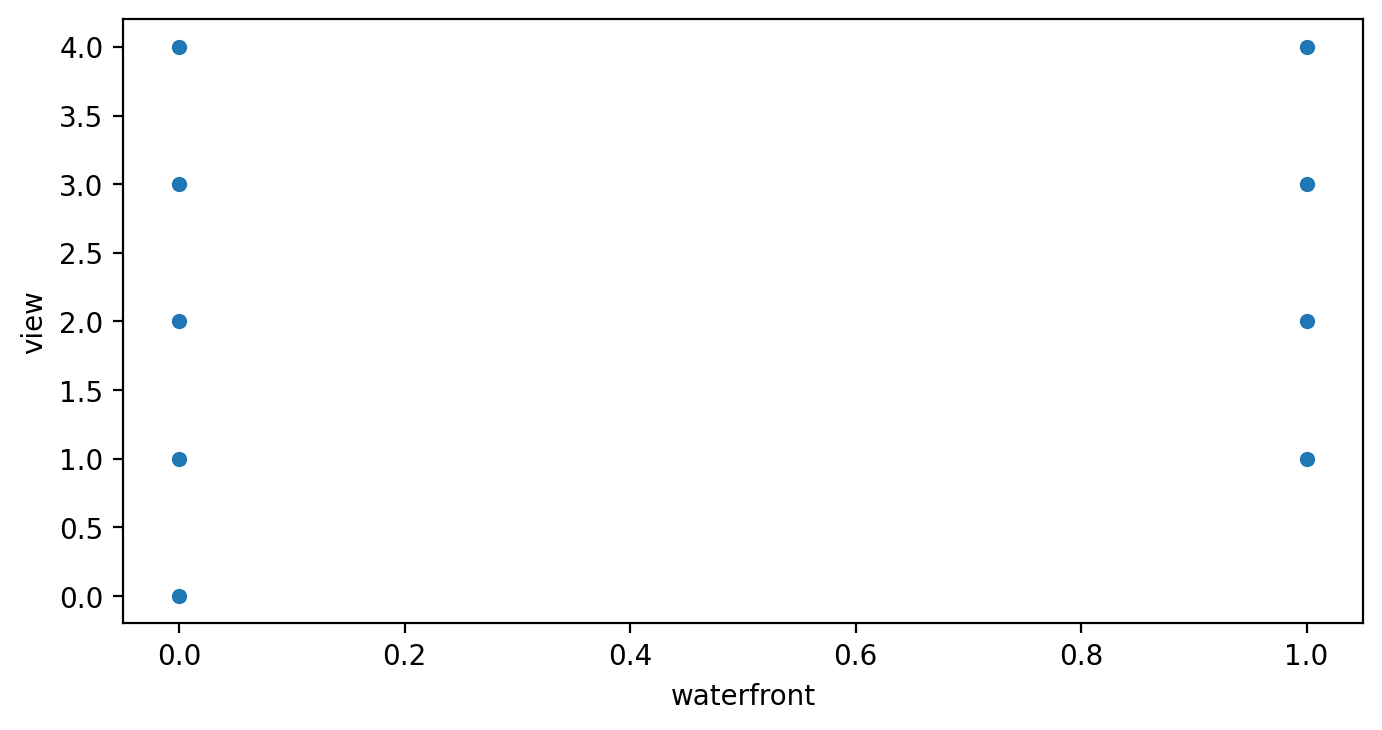

In [384]:
#waterfront와 view 관계 확인 
plt.figure(figsize = (8, 4),dpi = 100)
sns.scatterplot(data = data, x = 'waterfront', y = 'view')
plt.show()

####total_grade  
grade와 price 사이에는 강한 상관관계를 보이는 것을 확인했으나  condition과 view의 경우 강한 상관관계가 있다고 볼 수 없다고 판단하였다.  
집이 물가에 있으면 view가 더 좋은지 확인했으나 waterfornt와 view의 관계가 뚜렸해 보이지 않았다.  
kaggle에서 view에 대한 구체적인 설명을 제시했으면 더 명확했을 것이다.  
그래서 total_grade라는 column을 별도로 만들고 집을 평가한 feature들을 모두 더한후 scatterplot을 그려보니 어느 정도 price와 상관관계가 있어 보였다.  

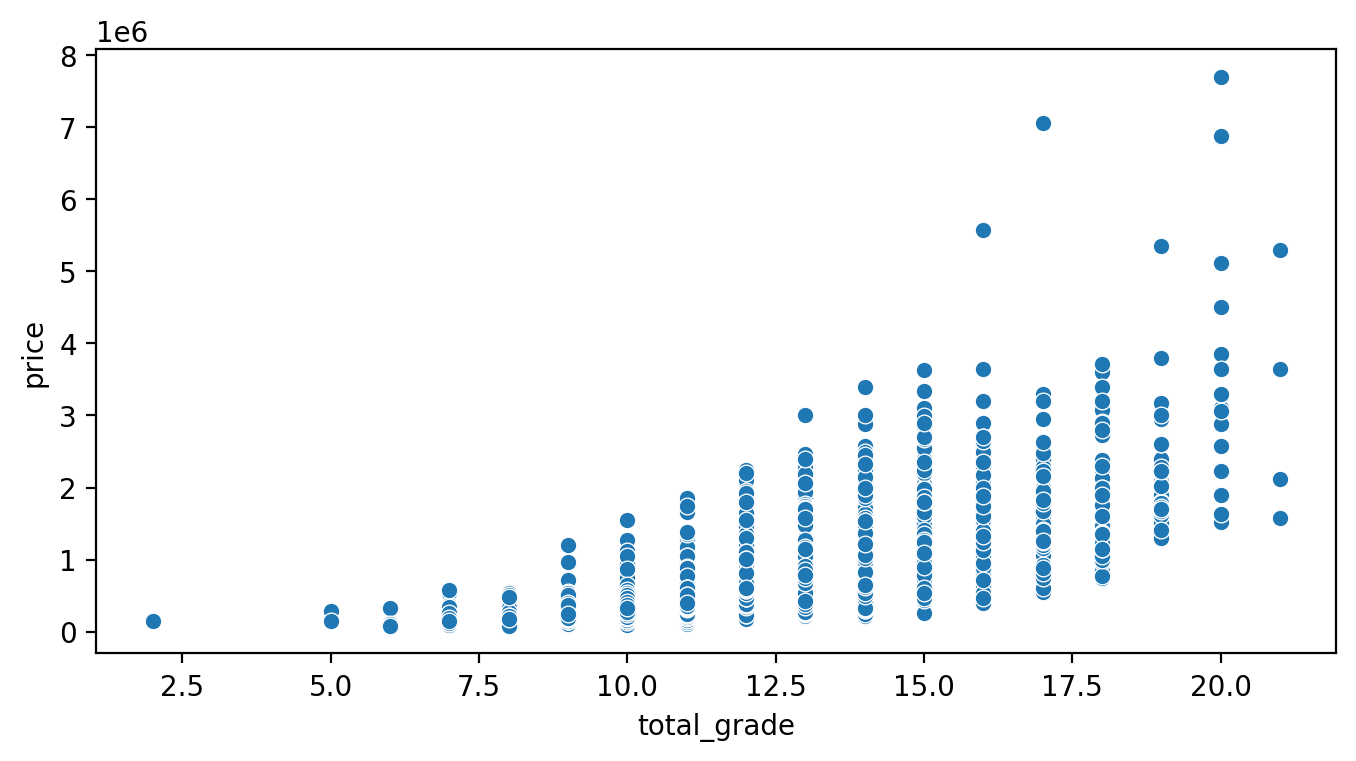

In [385]:
data['total_grade'] = data['grade'] + data['view'] + data['condition'] +data['waterfront']
plt.figure(figsize = (8, 4),dpi = 100)
sns.scatterplot(data = data, x = 'total_grade', y = 'price')
plt.show()

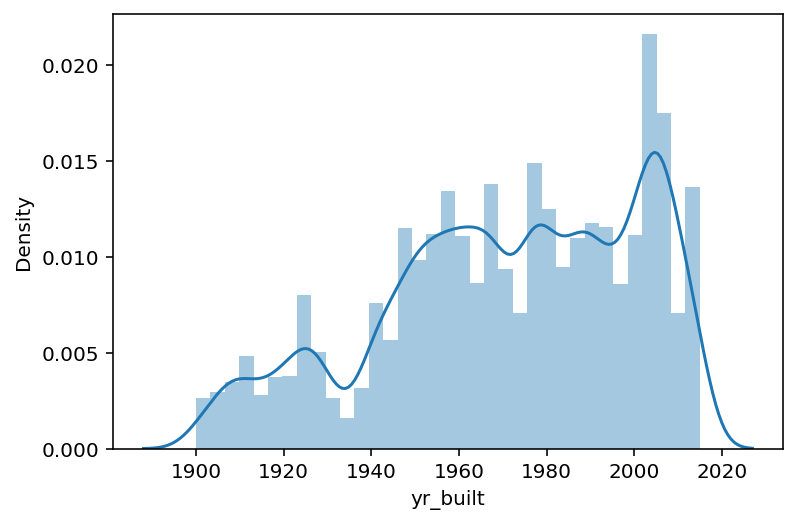

In [386]:
sns.distplot(data['yr_built'])

####yr_renovated  
yr_renovated는 분포가 0에 치우쳐 있고 0이 전체 95%를 차지하고 1인 경우가 2% 밖에 되지 않아 renovation을 한 경우를 1 아닌 경우를 0으로 binary encoding을 하기로 결정했다.  

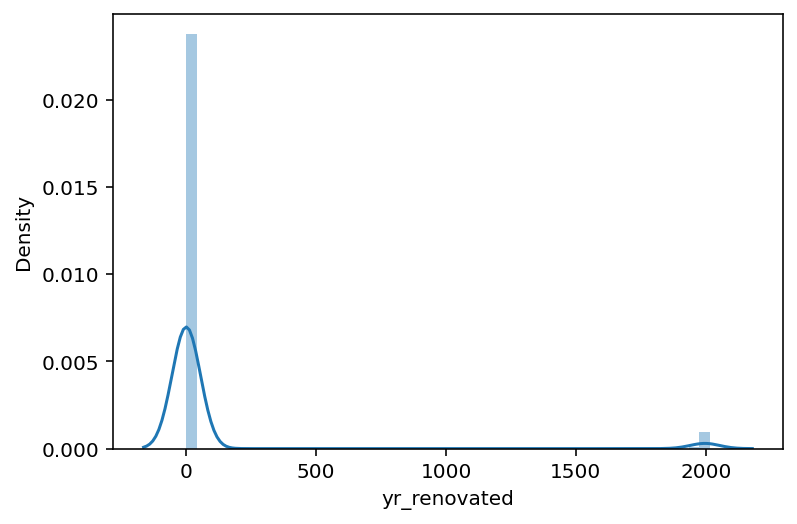

In [387]:
sns.distplot(data["yr_renovated"]) #데이터 0에 치우쳐 있음 

In [388]:
print(len(data.loc[data['yr_renovated']==0])) #renovate하지 않은 경우
print(len(data.loc[data['yr_renovated']==0])/len(data) * 100) #전체data에서 비율
print(len(data.loc[data['yr_renovated']>=2000])) #2000년 이후 renovate한 경우
print(len(data.loc[data['yr_renovated']>=2000])/len(data) * 100) #전체 데이터 비율 

20590
95.75408082593127
458
2.1299353578570432


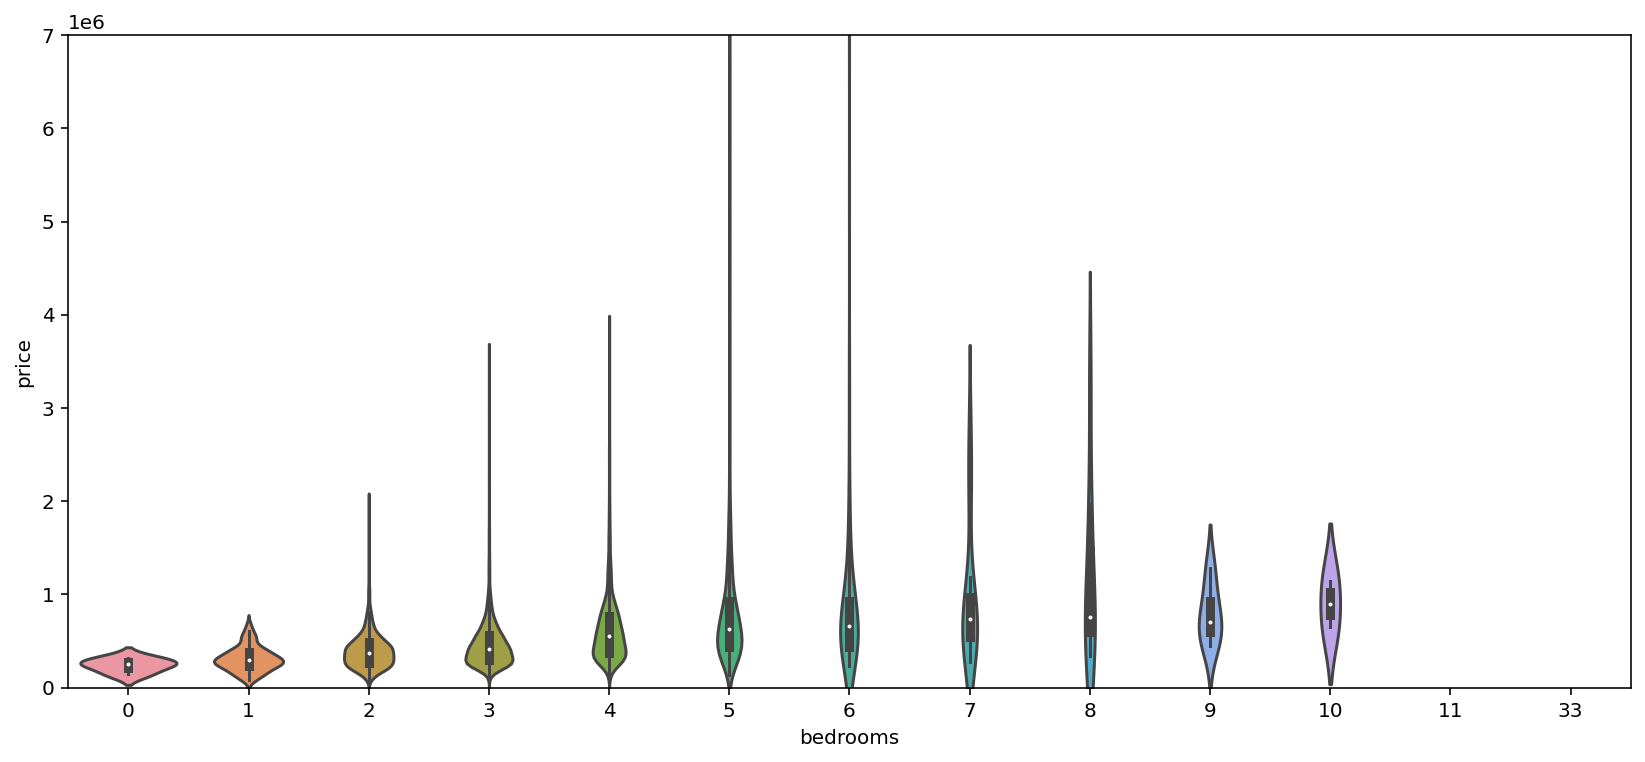

In [389]:
#침실이 0~6개인 경우는 침실이 늘어남에 따라 가격이 증가하지만 9, 10개 일 때는 다른 요소가 집 가격을 결정하는 것 같음 
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x='bedrooms', y="price", data=data)
fig.axis(ymin=0, ymax=7000000);

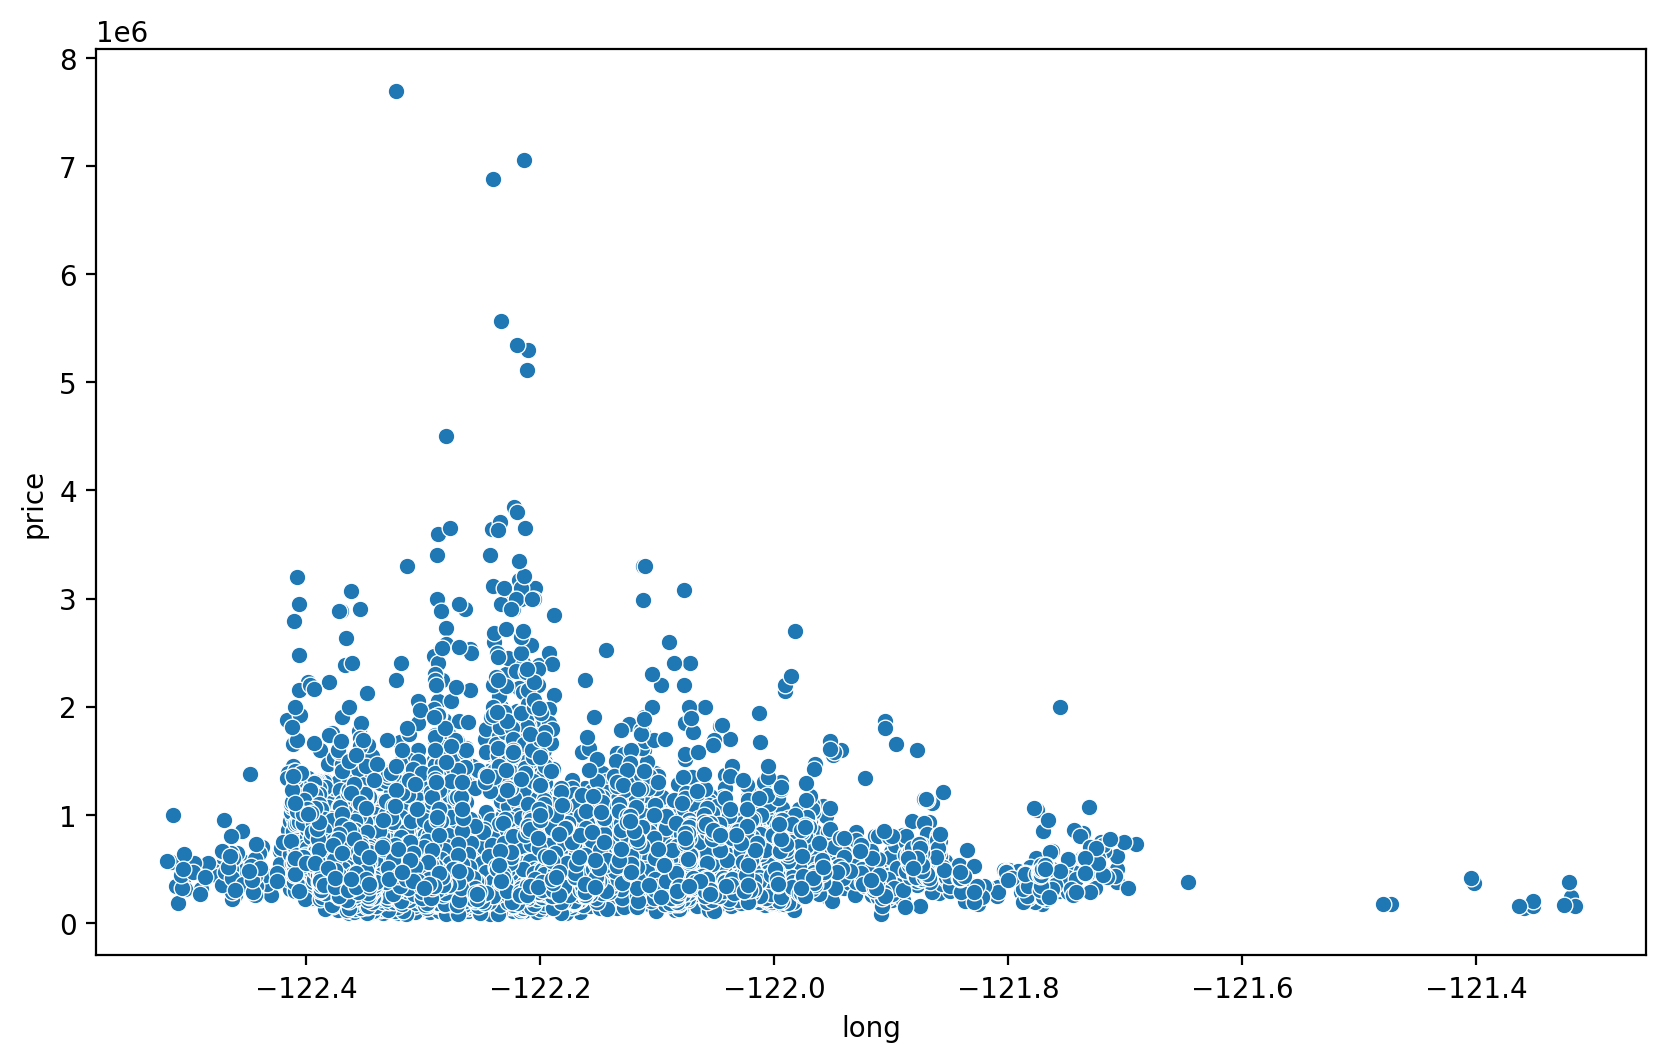

In [390]:
# impact of logitude on price => -122.4 ~ -122.0 사이에 높은 집값 몰려 있음 
plt.figure(figsize = (10, 6), dpi = 100)
sns.scatterplot(data = data, x = 'long', y = 'price')
plt.show()

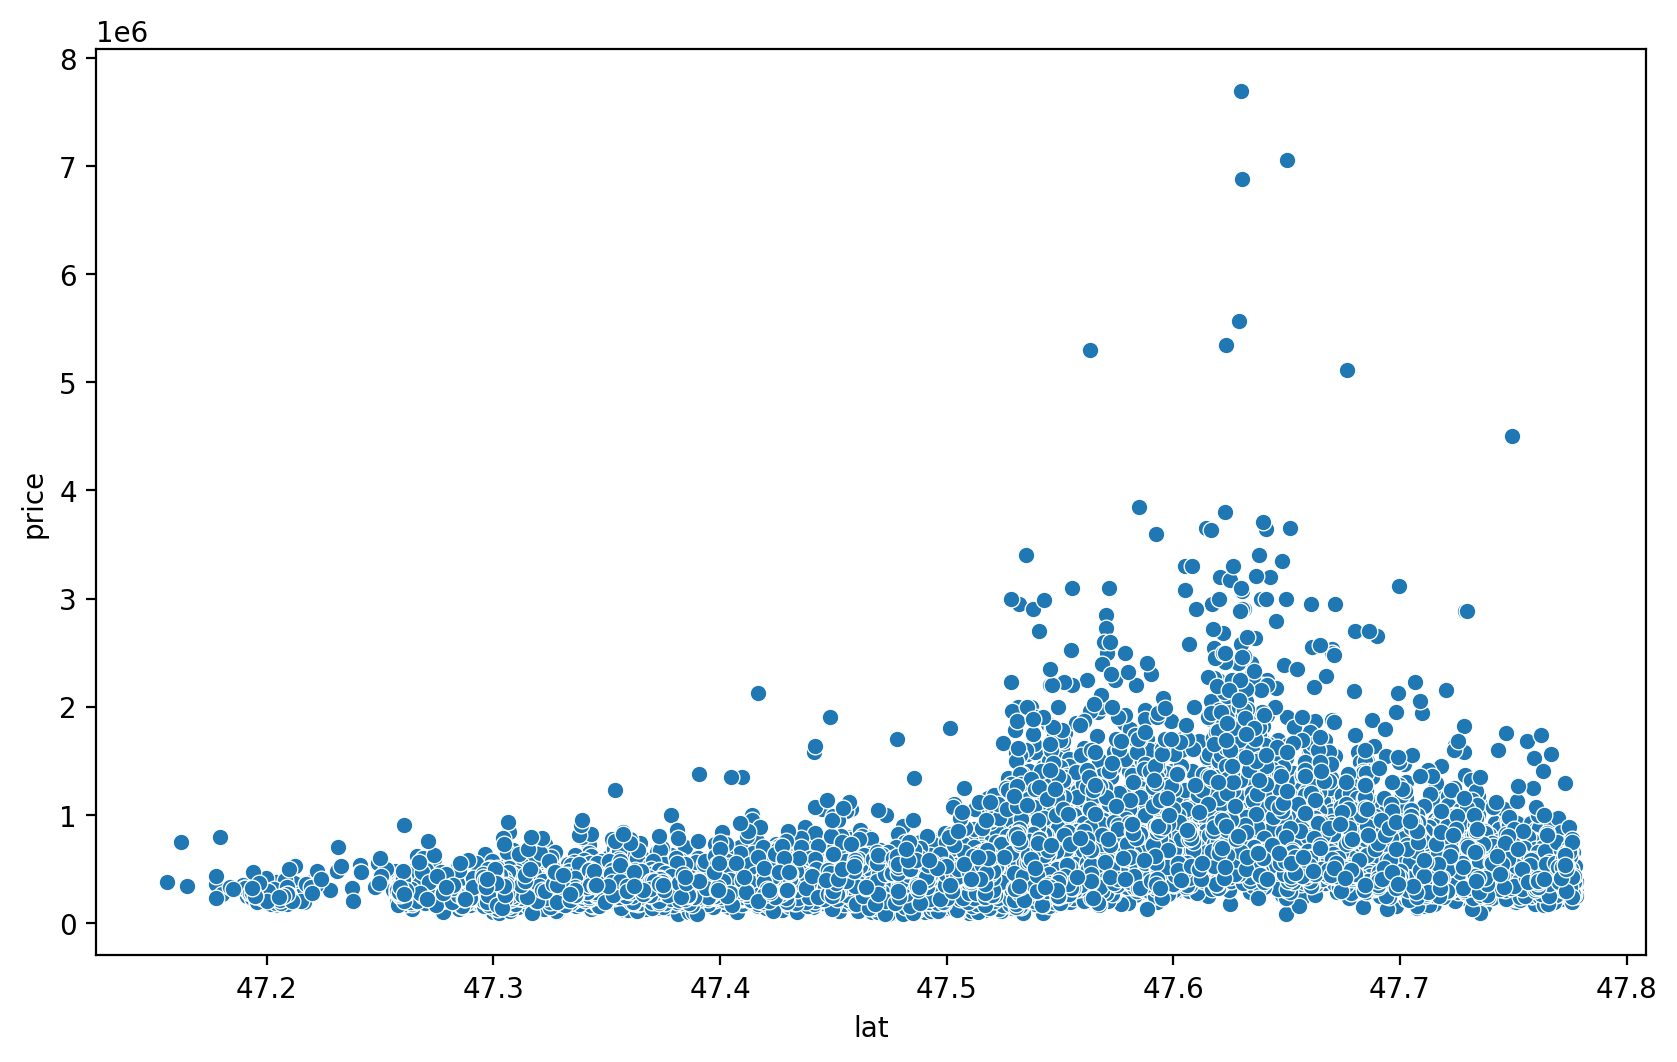

In [391]:
# impact of latitude on price 47.5 ~ 47.8 사이에 높은 집 값 몰려있음 
plt.figure(figsize = (10, 6), dpi = 100)
sns.scatterplot(data = data, x = 'lat', y = 'price')
plt.show()

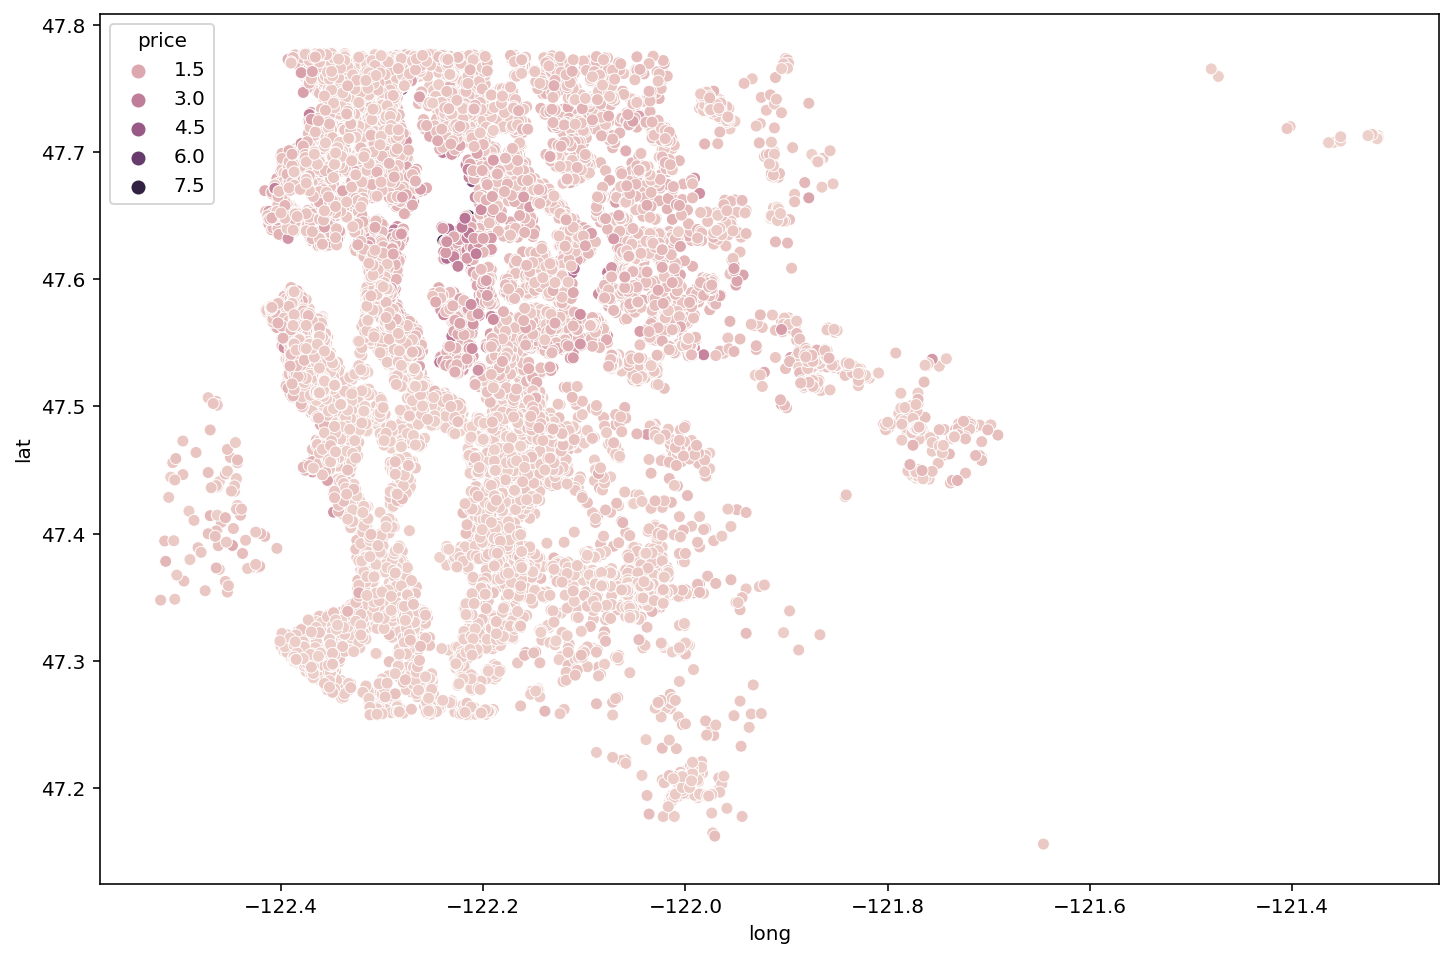

In [392]:
# display log asnd lat together(위도, 경도로 위치 표시)
plt.figure(figsize=(12,8))
sns.scatterplot(x='long',y='lat',data=data,hue='price')
plt.show()

##Feature Engineering  
ID : 삭제  
date : int형 변경  
price : label, 로그 변환  
bedrooms : 그대로 둠  
bathrooms : 그대로 둠  
sqft_living : 로그 변환  
sqft_lot : 로그 변환  
floors : 그대로 둠  
waterfront : 그대로 둠  
view : 그대로 둠  
condition : 그대로 둠  
grade : 그대로 둠  
sqft_above : 로그 변환  
sqft_basement : 로그 변환  
yr_built : 그대로 둠  
yr_renovated : binary encoding  
zipcode : str형 변형  
lat : PCA 차원축소  
long : PCA 차원축소  
sqft_living15 : 로그 변환  
sqft_lot15 : 로그 변환  
total_grade: grade + condition + view + waterfront  
count: zipcode별 갯수  





In [393]:
data.head(2)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_encoding,sqpt,total_grade
0,201410,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,0.0,1180,10
1,201502,180000.0,2,1.0,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,0.0,770,9


In [394]:
data.shape

(21503, 23)

In [428]:
#price 로그 변환 
data['price'] = np.log1p(data['price'].values)

In [429]:
#치우친 컬럼 로그 변환
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values) #로그 변환

In [430]:
#renovate 했으면 1 아니면 0으로 encoding
data.loc[train['yr_renovated'] > 0] = 1

In [431]:
data['total_grade'] = data['grade'] +  data['condition'] + data['view'] + data['waterfront']

In [432]:
#lat, long PCA
#for i in data:
lat_long = data[['lat', 'long']]
pca = PCA(n_components=2)
pca.fit(lat_long)

lat_long_pca = pca.transform(lat_long)

data['lat_long1'] = lat_long_pca[:, 0]
data['lat_long2'] = lat_long_pca[:, 1]

In [433]:
#zipcode삭제 
data.drop(['zipcode'], axis = 1, inplace = True)
#lat 삭제
data.drop(['lat'], axis = 1, inplace = True)
#long 삭제
data.drop(['long'], axis = 1, inplace = True)

In [504]:
#(15035, 21)
#(6468, 20)
train_data = data[:15035]
test_data = data[15035:]
y = train_data['price']
train_data.drop(['price'], axis = 1, inplace = True)

In [435]:
#train_data 결측치 없음 
for c in train_data.columns:
    print('{} : {}'.format(c, len(train_data.loc[pd.isnull(train_data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
sqft_living15 : 0
sqft_lot15 : 0
zipcode_encoding : 0
total_grade : 0
lat_long1 : 0
lat_long2 : 0


In [530]:
#test data 결측치 확인 
test_data.drop(['price'], axis = 1, inplace = True)
for c in test_data.columns:
    print('{} : {}'.format(c, len(test_data.loc[pd.isnull(test_data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
sqft_living15 : 0
sqft_lot15 : 0
zipcode_encoding : 0
total_grade : 0
lat_long1 : 0
lat_long2 : 0


##모델 설계

In [439]:
#rmse 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [440]:
#모델 정의
#Average Blending: gboost, xgboost, lightgbm 사용
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

###Cross Validation  
*이탤릭체 텍스트*

In [441]:
#Cross Validation:교차 검증을 통해 모델의 성능을 간단히 평가 
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train_data.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train_data.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models) #3개 트리 모델이 모두 훈련 데이터에 대해 괜찮은 성능 보여줌

Model: GradientBoosting, CV score:0.9949
[12:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model: XGBoost, CV score:0.9949
Model: LightGBM, CV score:0.9958


###Blend

In [443]:
#AveragingBlending 함수: 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내에 준다. 
def AveragingBlending(models, train_data, y, test_data):
    for m in models : 
        m['model'].fit(train_data.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test_data.values) for m in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, train_data, y, test_data)
print(len(y_pred))
y_pred

[12:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6468


array([13.14305277, 13.1128273 , 14.06927534, ..., 12.98139974,
       12.7446295 ,  0.99320213])

###Model Tuning  

In [444]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [445]:
#각 모델 별로 학습 및 예측 해보기 
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train_data, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[12:11:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 114324.5891925321,
 'LGBMRegressor': 101753.28403743352,
 'RandomForestRegressor': 116658.51507732809,
 'XGBRegressor': 115526.5966811916}

###Hyperparameter Tuning 하기 전 성능  

In [446]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

get_scores(models, train_data, y)

[12:13:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
RandomForestRegressor,116658.515077
XGBRegressor,115526.596681
GradientBoostingRegressor,114324.589193
LGBMRegressor,101753.284037


###GridSearchCV Hyperparameter Tuning  
이미 목표치인 110000 미만의 성능이 나왔으나 GridSearchCV로 Hyperparameter tuning을 시도했다.  

lightgbm라이브러리의 인자  
max_depth : 의사 결정 나무의 깊이, 정수 사용  
learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001 ~ 0.1 사이의 실수 사용  
n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용  
num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수  
boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력  

In [454]:
# GridSearch
def GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = -1 * results['score']
    results = results.sort_values(['RMSLE'])

    return results

In [533]:
# save_submission 
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test) #test 예측 
    prediction = np.expm1(prediction) #예측값 np.expm1으로 변환

    data_dir = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction

    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', rmsle) #파일 이름에 모델 종류와 RMSLE 값 넣어주기 
    submission.to_csv(submission_csv_path, index=False)
    print('{}saved!'.format(submission_csv_path))

In [492]:
#def save_model(y_pred, model_name, rmsle=None):
#    data_dir = './data'
#    submission_path = join(data_dir, 'sample_submission.csv')
#    submission = pd.read_csv(submission_path)
    
#    submission['price'] = np.expm1(y_pred)
    
#    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
#    submission.to_csv(submission_csv_path, index=False)
#    print('{} saved!'.format(submission_csv_path))

In [505]:
#parameter 설정
param_grid = {
    #'max_depth': [8],
    #'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    'learning_rate': [0.1],
    #'learning_rate:[0.1, 0.01, 0.001]
    'n_estimators': [2000],
    #n_estimators: [50, 100, 500, 1000]
    'num_leaves':[4, 5, 6],
    'boosting_type': ['dart']
}

In [506]:
model = LGBMRegressor(random_state=random_state)

In [507]:
GridSearch(model, train_data, y, param_grid) #모델 학습 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,boosting_type,learning_rate,n_estimators,num_leaves,score,RMSLE
2,dart,0.1,2000,6,-0.168877,0.168877
1,dart,0.1,2000,5,-0.171175,0.171175
0,dart,0.1,2000,4,-0.177380,0.177380


In [520]:
lgbmregressor0 = LGBMRegressor(random_state=random_state)
lgbmregressor1 = LGBMRegressor(boosting='gbdt', learning_rate=0.1, n_estimators=2000, num_leaves=6, max_depth=2, random_state=random_state)

In [521]:
models = [lgbmregressor0, lgbmregressor1]
get_scores(models, train_data, y)

,RMSE
LGBMRegressor,100309.429189


In [534]:
save_submission(lgbmregressor0, train_data, y, test_data, "LGBMRegressor", rmsle='100309.429189')

/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_100309.429189.csvsaved!


##Discussion  
최종 성능은 LGBMRegressor, 100309.429189였다.  
GPU를 사용했어도 GridSearchCV는 학습 시간이 너무 오래걸렸다.  
그래서 대략적인 범위만 정하고 학습을 시킨 후 가장 좋은 성능이 나왔던 파라미터를 선택하고 조금씩 수정해줬다.  
GridSearchCV를 통해 파라미터를 조정하면 더 나은 성능이 나올 것으로 예상했으나 오히려 성능이 떨어졌다. 왜 그런지는 모르겠어서 이에대해 학우들과 나누면 좋을 거 같다.  
모델을 만들면서 크게 와닿았던 점은feature engineering이 중요한 것 같았다.  
zipcode나 lat와 long feature 같이 위치를 다루는 feature들의 경우에 내가 설정한 encoding과 pca로 바꿔주는게 맞는 건지 확신이 없었다.  
특히 zipcode는 encoding 할 때 삽질을 많이해서 하루가 꼬박 걸렸다.  
이러한 feature들은 많은 경험이 있어야 더 정확하게 다룰 수 있을 것 같다.    



##Kaggle 제출  
lgbmregressor 모델 RMSLE 100309.429189로 제출했다.  

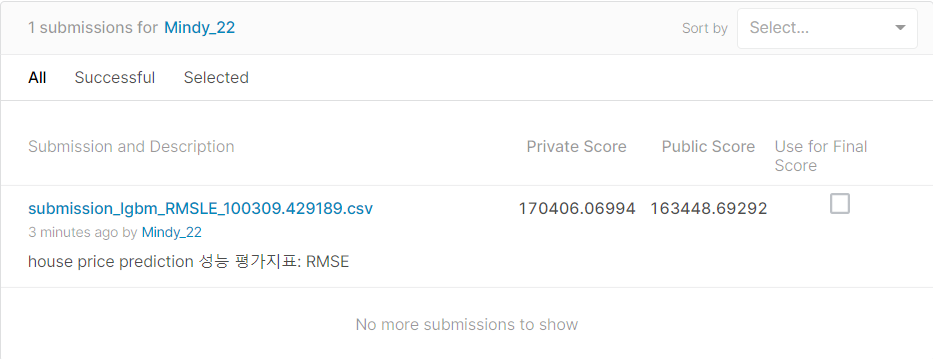